In [687]:
# !pip install scikit-learn --upgrade

In [688]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer, TargetEncoder, OneHotEncoder, StandardScaler, QuantileTransformer
from dateutil.parser import parse
from matplotlib import pyplot as plt
import seaborn as sns

# Описание задачи

Решается задача многоклассовой классификаций, в рамках которой каждому фильму сопоставляется класс на основании его кассовых сборов. Важно заметить, что в других исследованиях (например, [тут](https://www.researchgate.net/publication/322138608_A_Machine_Learning_Approach_to_Predict_Movie_Box-Office_Success) и [тут](https://www.semanticscholar.org/reader/3925582b25c9896b1373100290556396534e55e6)) для определения класса фильма используются диапазоны с аболютными значениями в денежных единицах. Напротив, в данном исследовании диапазоны будут определятся бюджетом фильма. Это связано с тем, что дорогой фильм (300 млн. у.е.) с широкомастабной рекламной компанией, собравший огромную кассу (700 млн. у.е.) по сравнению с другими фильмами, может оказаться убыточным. С другой стороны, малобюджетный фильм (например, 1 млн у.е.) может собрать относительно скромную кассу (20 млн. у.е.), но при этом оказаться очень прибыльным. Все это связнао с тем, что, создатели фильма получают не всю сумму сборов, часть распределяется между различными участниками рынка (кинотеатры/дистриьюторы и агенты), часть уходит на рекламу и маркетинг, часть уплачивается как налог ([источник](https://stephenfollows.com/how-a-cinemas-box-office-income-is-distributed/)). В данном исследовании принято, что кинотеатры и дистрибьюторы забирают 50% от сборов, затраты на рекламу и маркетинг равны 0.

В данной работае выделены следующие классы (P - revenue - сборы, B - budget - бюджет):
* 0: R < 1\*B
* 1: 1\*B <= R < 2\*B
* 2: 2\*B <= R < 4\*B
* 3: 4\*B <= R

# Методы оценки
* Exact match
* 1-class-away accuracy

# Обработка данных

In [689]:
df = pd.read_csv('./movie_dataset.csv', index_col=0)

## Очистка данных

В исходном наборе данных имеются поля, которые не понадобятся при обучении:
* Идентификаторы в самом наборе данных (`id`) и во внешней системе (`imdb_id`)
* Слоган (`tagline`)
* Краткое описание фильма (`overview`)
* Количество оценок (`vote_count`) и средняя оценка (`vote_average`), поскольку в данной работе прогнозирование проводится по данным, известным до выхода фильма в прокат
* Сборы на первой неделе в стране-производителе фильма (`domestic_opening`)
* Оригинальное название (`original_title`) и просто название (`title`)
* Языки, на котором разговаривают персонажи фильма (`spoken_languages`)

In [690]:
df = df.drop(columns=['id', 'imdb_id', 'tagline', 'overview', 'vote_average', 'vote_count', 'domestic_opening', 'original_title', 'title', 'spoken_languages'])

In [691]:
df.columns

Index(['genres', 'original_language', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'status',
       'domestic_distributor', 'mpaa', 'budget', 'revenue', 'actors',
       'director'],
      dtype='object')

Удаляем строки, в которых есть хотя бы один признак без значения

In [692]:
df['budget'] = df['budget'].replace({0: np.NAN})
df['revenue'] = df['revenue'].replace({0: np.NAN})
df['runtime'] = df['runtime'].replace({0: np.NAN})

df.dropna(inplace=True)

Также удалим все фильмы, которые не выпущены в прокат. Затем удалим аттрибут, связанный с этой информацией (`status`)

In [693]:
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], axis=1)

## Формирование целевой переменной

Сформируем целевую переменную по имеющимся бюджету и сборам. Правила соотнесения сборов и класса приведены выше в описании задачи.

In [694]:
def get_class(row):
  R = row['revenue']
  B = row['budget']
  if R < B:
    return 0
  elif B <= R < 2*B:
    return 1
  elif 2*B <= R < 4*B:
    return 2
  elif 4*B <= R:
    return 3
  return np.NAN

df['target'] = df.apply(get_class, axis=1)

In [695]:
df['target'].value_counts()

target
0    1484
2    1018
3     927
1     843
Name: count, dtype: int64

Видно, что классы сбалансированы.

## Извлечение и преобразование признаков

При обучении модели будут использоваться следующие признаки:
* Жанры
* Язык картины
* Продюсерская компания
* Страна производства
* Месяц выхода
* Продолжительность
* Компания-дистрибьютор фильма в стране производства
* Возрастной рейтинг фильма
* Бюджет
* Актеры
* Режиссер

Выделяем категориальные и непрерывные признаки

In [696]:
cont = ['runtime', 'budget']
categ = []
for col in df.columns:
  if col not in cont:
    categ.append(col)

### Категориальные признаки

Посчитаем количество возможных значений у категориальных переменных, но сначала преобразуем сырые строки в Python-объекты для некоторых полей.

In [697]:
literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']

for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

In [698]:
for cat in categ:
  print(cat, df[cat].explode().nunique())

genres 19
original_language 30
production_companies 4711
production_countries 75
release_date 2888
domestic_distributor 215
mpaa 10
revenue 4196
actors 4296
director 1852
target 4


#### Жанры

Всего в датасете присутствуют 19 различных жанров: триллер, музыка, мистика, драма, история, криминал, документальный, военный, зарубежный, ужасы, экшн, комедия, фантастика, романтика, приключения, семейный, анимация, научная фантастика, вестерн. Причем фильму могут соответсвовать несколько жанров. Поэтому данный признак будет кодироваться следующим образом:
1. Вектор длины 19 заполняется нулями, каждая позиция которого соответствует одному определенному жанру.
2. Проставляются единицы в тех позициях, которые соответствуют жанрам фильма.

In [699]:
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(df['genres'])
classes = ['genre_' + x.replace(' ', '_').lower() for x in mlb.classes_]
df = df.join(pd.DataFrame(dum.astype(bool), df.index, classes))

genres = set(mlb.classes_)
print('Количество жанров:', len(genres))
print('Жанры: ', genres)

df = df.drop(columns=['genres'], axis=1)

Количество жанров: 19
Жанры:  {'Thriller', 'Music', 'Mystery', 'Drama', 'History', 'Crime', 'Documentary', 'War', 'Foreign', 'Horror', 'Action', 'Comedy', 'Fantasy', 'Romance', 'Adventure', 'Family', 'Animation', 'Science Fiction', 'Western'}


#### Оригинальный язык

In [700]:
df['original_language'].value_counts()

original_language
en    4015
fr      67
es      33
ja      22
zh      21
de      14
ko      12
da      11
it      10
fa      10
cn       9
pt       6
sv       5
ru       5
nl       5
no       4
hi       4
hu       3
he       3
th       2
id       2
nb       1
tr       1
pl       1
cs       1
fi       1
af       1
ps       1
bs       1
ro       1
Name: count, dtype: int64

В датасете преобладают фильмы на английском языке, поэтому данный признак будет кодироваться так: если фильм на английском, то 1, иначе 0.

In [701]:
df['original_language'] = df.apply(lambda row: 1 if row['original_language'] == 'en' else 0, axis=1)

#### Продюсерская компания

Данный признак представлен в виде массива, т.к. при создании фильма могут участвовать несколько компаний. Также в исходном датасете очень много различных компаний (4711), поэтому здесь не получится применить ту же технику, что и для жанров, поскольку в таком случае датасет будет сильно разреженным, что может ухудшить точность модели. Посмотрим, как часто встречаются те или иные компаний.

In [702]:
df['production_companies'].explode().value_counts()

production_companies
Warner Bros.                              347
Universal Pictures                        304
Paramount Pictures                        265
Twentieth Century Fox Film Corporation    218
Columbia Pictures                         199
                                         ... 
Flux Films                                  1
High Line Productions                       1
Tiny Dancer Films                           1
New Century Entertainment Corporation       1
Acacia Filmed Entertainment                 1
Name: count, Length: 4711, dtype: int64

Признак будет кодироваться следующим образом:
1. Для каждой компании будут просуммированы кассовые сборы всех фильмов, в продюсировании которых они принимали участие.
2. Массив компаний будет кодироваться суммой числовых значений, полученных в п. 1.

In [703]:
def cumulative_revenue_replacer(column, iterable=True):
  entities = df[column].explode().tolist()
  entities_revenue = {}
  for e in entities:
    entities_revenue[e] = 0

  for index, row in df.iterrows():
    if iterable:
      for e in row[column]:
        entities_revenue[e] += row['revenue']
    else:
      entities_revenue[row[column]] += row['revenue']

  def entity_to_cumulative_revenue(entity):
    return entities_revenue[entity]

  def f(row):
    if iterable:
      return sum(list(map(entity_to_cumulative_revenue, row[column])))
    else:
      return entities_revenue[row[column]]

  return f

df['production_companies'] = df.apply(cumulative_revenue_replacer('production_companies'), axis=1)

#### Страна производства

In [704]:
df['production_countries'].explode().value_counts()

production_countries
US    3759
GB     577
FR     343
DE     331
CA     223
      ... 
AW       1
BS       1
AF       1
MY       1
PA       1
Name: count, Length: 75, dtype: int64

Данный признак будет кодироваться так же, как и признак "Продюсерская компания"

In [705]:
df['production_countries'] = df.apply(cumulative_revenue_replacer('production_countries'), axis=1)

#### Месяц выхода

Сначала необходимо извлечь месяц выхода фильма

In [706]:
m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
df = df.join(m.rename('release_month'))
df = df.drop(columns=['release_date'], axis=1)

Месяц выхода будет закодирован с помощью техники one-hot encoding, т.к. количество возможных значений (12) не велико.

In [707]:
one_hot_enc = OneHotEncoder(sparse_output=False)

mpaa_encoded = one_hot_enc.fit_transform(df[['release_month']])
classes = [f'release_month_{x}' for x in one_hot_enc.categories_[0]]
df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))

#### Компания-дистрибьютор фильма в стране производства

In [708]:
df['domestic_distributor'].explode().value_counts()

domestic_distributor
Warner Bros.                           473
Twentieth Century Fox                  339
Universal Pictures                     333
Sony Pictures Releasing                293
Walt Disney Studios Motion Pictures    291
                                      ... 
Orion Classics                           1
Dragon Dynasty                           1
Ascendant Pictures                       1
Romar Entertainment                      1
Annapurna Pictures                       1
Name: count, Length: 215, dtype: int64

В датасете 215 возможных значений для данного признака (не применима техника one hot encoding). У каждого фильма ровно 1 дистрибьютор (в рамках датасета). Таким образом, применим использованную ранее технику кодирования с заменой дистриьютора на его суммарные сборы (см. "Продюсерская компания" и "Страна производства").

In [709]:
df['domestic_distributor'] = df.apply(cumulative_revenue_replacer('domestic_distributor', iterable=False), axis=1)

mpaa 10
actors 4296
director 1852

#### Возрастной рейтинг

In [710]:
df['mpaa'].value_counts()

mpaa
R            2147
PG-13        1445
PG            604
G              52
NC-17          15
M/PG            3
GP              3
Approved        1
M               1
Not Rated       1
Name: count, dtype: int64

Количество классов мало, поэтому можно применить one hot encoding. Однако есть классы, к которым принадлежит небольшое количество фильмов. Удалим классы, у которых меньше 15 экземпляров: `M/PG`, `GP`, `Approved`, `M` и `Not Rated`. Это позволит уменьшить разреженность итогового датасета.

In [711]:
to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
df = df[~df['mpaa'].isin(to_delete)]

Применим one hot encoding

In [712]:
one_hot_enc = OneHotEncoder(sparse_output=False)

mpaa_encoded = one_hot_enc.fit_transform(df[['mpaa']])
classes = [('mpaa_' + x.upper()) for x in one_hot_enc.categories_[0]]
df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))

df = df.drop(columns=['mpaa'], axis=1)

#### Актёры

У фильмов может быть любое количество актеров. В рамках данной работы ограничимся первыми тремя актерами, которые указываются в титрах.

In [713]:
df.apply(lambda row: len(row['actors']), axis=1).value_counts()

3    4254
2       4
0       3
1       2
Name: count, dtype: int64

Удалим строки, где количество актеров меньше 3

In [714]:
df = df[df['actors'].map(len) == 3]

Сначала каждый актер будет помещен в свой столбец, а затем применим технику с заменой имени актёра на сумму кассовых сборов всех его фильмов.

In [715]:
df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)

In [716]:
df['actor_1'] = df.apply(cumulative_revenue_replacer('actor_1', iterable=False), axis=1)
df['actor_2'] = df.apply(cumulative_revenue_replacer('actor_2', iterable=False), axis=1)
df['actor_3'] = df.apply(cumulative_revenue_replacer('actor_3', iterable=False), axis=1)

#### Режиссер

Аналогично закодируем режиссёра фильма

In [717]:
df['director'] = df.apply(cumulative_revenue_replacer('director', iterable=False), axis=1)

### Непрерывные признаки

Добавим к уже имеющимся непрерывным признакам те, которые были получены в процессе обработки категориальных признаков.

In [718]:
cont = cont + ['production_companies', 'production_countries', 'domestic_distributor', 'actor_1', 'actor_2', 'actor_3', 'director']

Посмотрим, какое распределение у непрерывных признаков

array([[<Axes: title={'center': 'runtime'}>,
        <Axes: title={'center': 'budget'}>,
        <Axes: title={'center': 'production_companies'}>],
       [<Axes: title={'center': 'production_countries'}>,
        <Axes: title={'center': 'domestic_distributor'}>,
        <Axes: title={'center': 'actor_1'}>],
       [<Axes: title={'center': 'actor_2'}>,
        <Axes: title={'center': 'actor_3'}>,
        <Axes: title={'center': 'director'}>]], dtype=object)

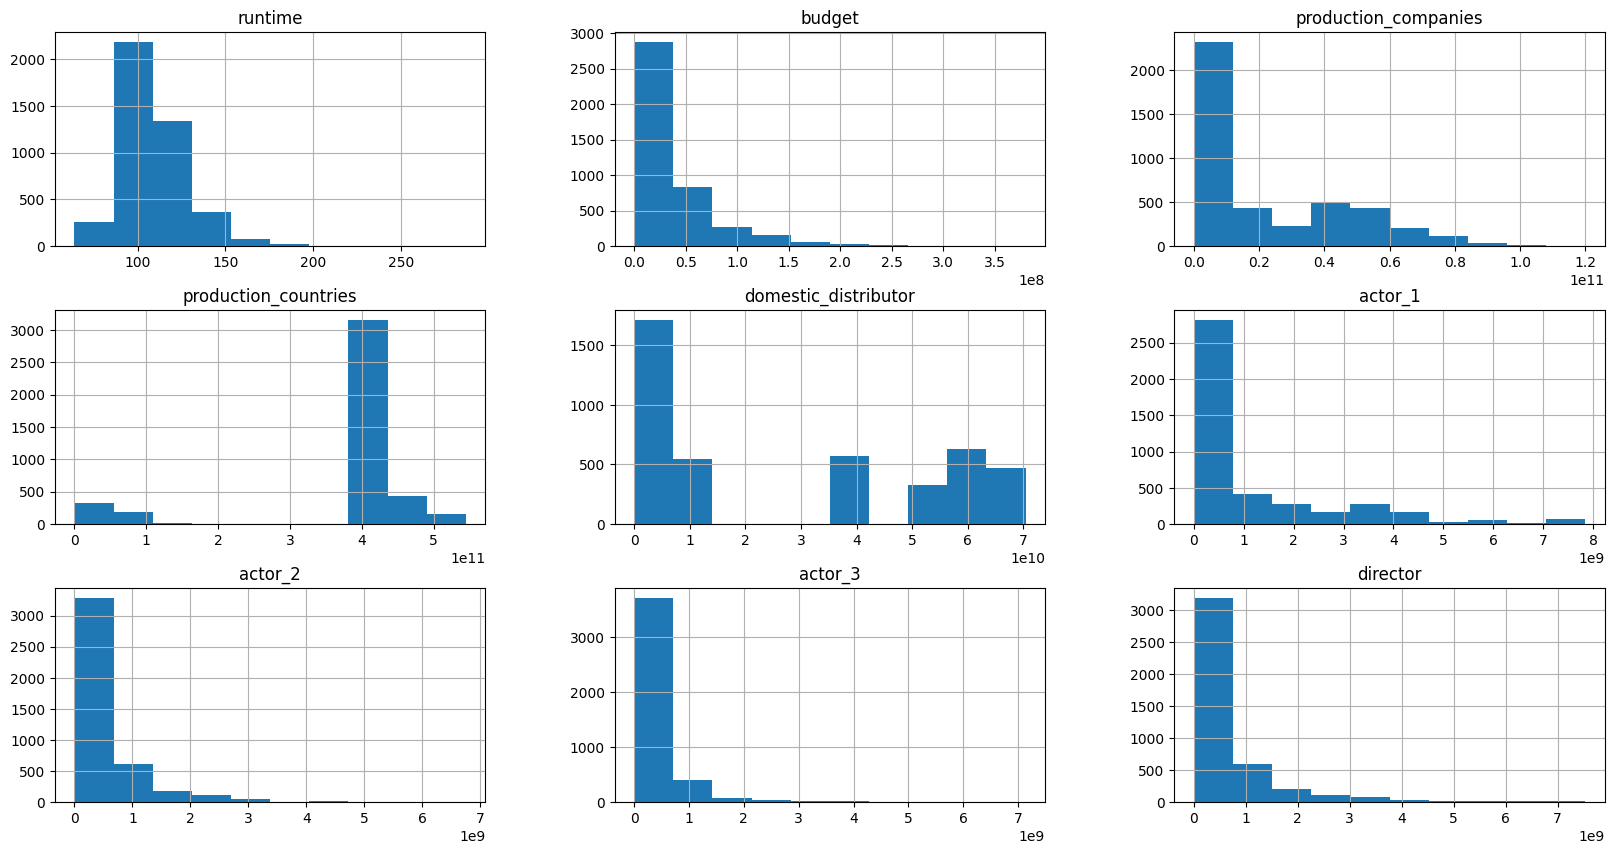

In [719]:
df.hist(cont, figsize=(20, 10))

Видно, что продолжительность (`runtime`) имеет распределение, близкое к нормальноу, а бюджет (`budget`) - степенное.

In [720]:
for col in cont:
    scaler = StandardScaler()
    # scaler = QuantileTransformer(output_distribution='normal', random_state=0)
    df[col] = scaler.fit_transform(df[[col]])

array([[<Axes: title={'center': 'runtime'}>,
        <Axes: title={'center': 'budget'}>,
        <Axes: title={'center': 'production_companies'}>],
       [<Axes: title={'center': 'production_countries'}>,
        <Axes: title={'center': 'domestic_distributor'}>,
        <Axes: title={'center': 'actor_1'}>],
       [<Axes: title={'center': 'actor_2'}>,
        <Axes: title={'center': 'actor_3'}>,
        <Axes: title={'center': 'director'}>]], dtype=object)

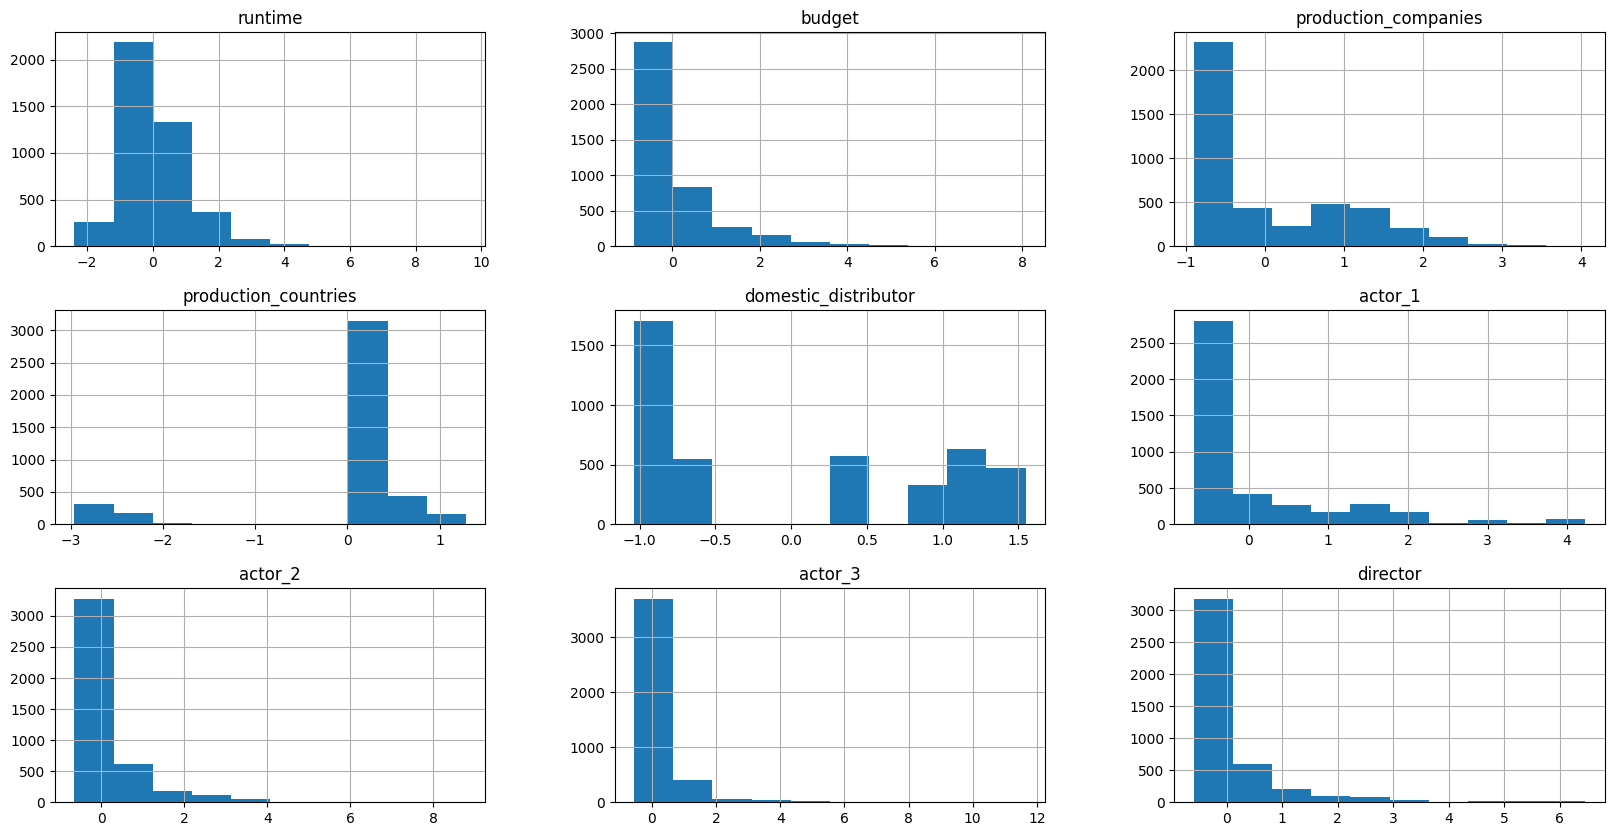

In [721]:
df.hist(cont, figsize=(20, 10))

#### Бюджет

#### Продолжительность

# Построение и обучение модели

In [736]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

target = df['target']

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target), y=target)
class_weights = {i: x for i, x in enumerate(class_weights)}

y = to_categorical(target)
X = df.drop(['revenue', 'target'], axis=1).values.astype(float)

Разбиваем исходный датасет следующим образом: 90% - тренировочный, 5% - валидационный, 5% - тестовый.

In [731]:
from sklearn.model_selection import train_test_split

X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=0.1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum ,test_size=0.5, stratify=y_dum)

In [756]:
from keras import layers
from keras.models import Model

def build_model(input_shape, num_classes):
    input = layers.Input(shape=input_shape)
    hidden = layers.Dense(32, activation='relu')(input)
    hidden = layers.Dense(64, activation='relu')(hidden)
    hidden = layers.Dense(128, activation='relu')(hidden)
    hidden = layers.Dense(64, activation='relu')(hidden)
    hidden = layers.Dense(32, activation='relu')(hidden)
    output = layers.Dense(num_classes, activation='softmax')(hidden)

    model = Model(inputs=input, outputs=output)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [747]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model

m = build_model(df.shape[1]-2, 4)

# Настриваем сохранение лучшей модели
checkpoint_path = "./best-model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Настраиваем callback для ранней остановки модели
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=5, verbose=1)
# Настраиваем callback для TensorBoard
tensorboard = TensorBoard(log_dir="./logs")

# Обучение модели
full_history = m.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    verbose=1,
    callbacks=[
        checkpoint,
        early_stopping,
        tensorboard,
    ],
)

Epoch 1/50
236/240 [============================>.] - ETA: 0s - loss: 1.3409 - accuracy: 0.3673
Epoch 1: val_accuracy improved from -inf to 0.38967, saving model to ./best-model.keras
240/240 [==============================] - 4s 9ms/step - loss: 1.3395 - accuracy: 0.3699 - val_loss: 1.2909 - val_accuracy: 0.3897
Epoch 2/50
232/240 [============================>.] - ETA: 0s - loss: 1.2799 - accuracy: 0.4103
Epoch 2: val_accuracy improved from 0.38967 to 0.40845, saving model to ./best-model.keras
240/240 [==============================] - 2s 8ms/step - loss: 1.2794 - accuracy: 0.4104 - val_loss: 1.2624 - val_accuracy: 0.4085
Epoch 3/50
238/240 [============================>.] - ETA: 0s - loss: 1.2356 - accuracy: 0.4407
Epoch 3: val_accuracy improved from 0.40845 to 0.41315, saving model to ./best-model.keras
240/240 [==============================] - 2s 7ms/step - loss: 1.2366 - accuracy: 0.4402 - val_loss: 1.2569 - val_accuracy: 0.4131
Epoch 4/50
238/240 [============================>

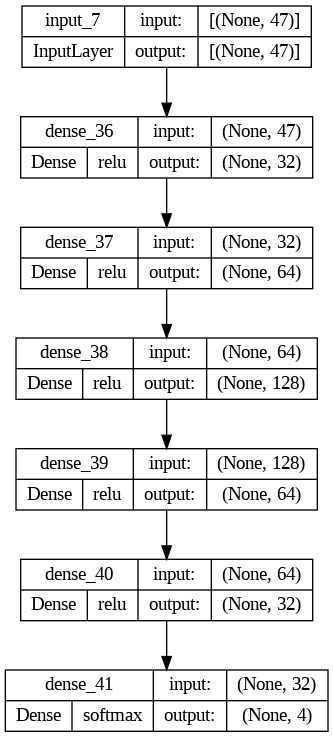

In [727]:
from keras.utils import plot_model

plot_model(m, show_shapes=True, show_layer_activations=True)

In [728]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Функция для оценки полученной модели
def inspect_model(model):
  results = model.evaluate(X_test, y_test, batch_size=128)
  print('test loss, test acc:', results)

  predictions = model.predict(X_test)
  matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
  ConfusionMatrixDisplay(matrix).plot()

2/2 [==============================] - 1s 12ms/step - loss: 1.2027 - accuracy: 0.4836
test loss, test acc: [1.2026983499526978, 0.48356807231903076]
7/7 [==============================] - 0s 4ms/step


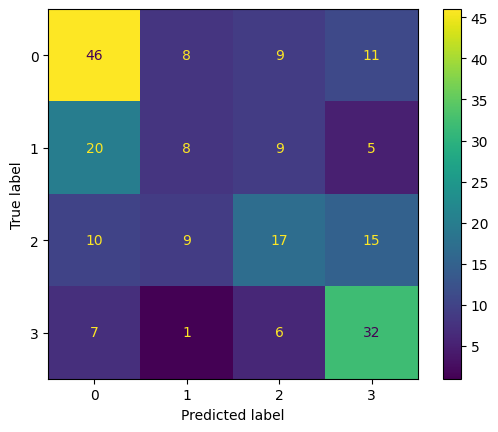

In [748]:
# Загрузка лучшей модели
best_model = load_model(checkpoint_path)
# Проверка лучшей модели
inspect_model(best_model)

In [760]:
(54+37+41+38) / (46+8+20+28+14+19+32+8+38)

0.7981220657276995

https://www.researchgate.net/publication/322138608_A_Machine_Learning_Approach_to_Predict_Movie_Box-Office_Success

Epoch 1/50
240/240 [==============================] - ETA: 0s - loss: 1.2745 - accuracy: 0.3668
Epoch 1: val_accuracy improved from -inf to 0.44601, saving model to ./best-model.keras
240/240 [==============================] - 10s 14ms/step - loss: 1.2745 - accuracy: 0.3668 - val_loss: 1.1275 - val_accuracy: 0.4460
Epoch 2/50
238/240 [============================>.] - ETA: 0s - loss: 1.1363 - accuracy: 0.4362
Epoch 2: val_accuracy improved from 0.44601 to 0.47887, saving model to ./best-model.keras
240/240 [==============================] - 3s 13ms/step - loss: 1.1382 - accuracy: 0.4360 - val_loss: 1.0437 - val_accuracy: 0.4789
Epoch 3/50
237/240 [============================>.] - ETA: 0s - loss: 1.1061 - accuracy: 0.4575
Epoch 3: val_accuracy did not improve from 0.47887
240/240 [==============================] - 3s 13ms/step - loss: 1.1040 - accuracy: 0.4582 - val_loss: 1.1736 - val_accuracy: 0.4742
Epoch 4/50
240/240 [==============================] - ETA: 0s - loss: 1.0620 - accura

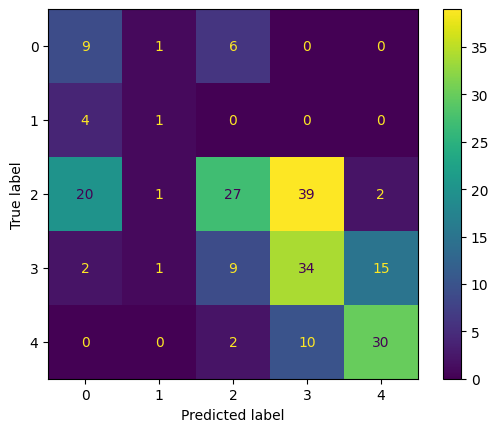

In [758]:
M = 1000000
def get_class_2(row):
  R = row['revenue']
  if R <= M / 2:
    return 0
  elif M / 2 < R <= M:
    return 1
  elif M < R <= 40*M:
    return 2
  elif 40*M < R <= 150*M:
    return 3
  elif 150*M < R:
    return 4
  return np.NAN

target = df.apply(get_class_2, axis=1)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target), y=target)
class_weights = {i: x for i, x in enumerate(class_weights)}

y = to_categorical(target)
X = df.drop(['revenue', 'target'], axis=1).values.astype(float)

X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=0.1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum ,test_size=0.5, stratify=y_dum)

m = build_model(df.shape[1]-2, 5)

# Настриваем сохранение лучшей модели
checkpoint_path = "./best-model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Настраиваем callback для ранней остановки модели
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=5, verbose=1)
# Настраиваем callback для TensorBoard
tensorboard = TensorBoard(log_dir="./logs")

# Обучение модели
full_history = m.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    verbose=1,
    callbacks=[
        checkpoint,
        early_stopping,
        tensorboard,
    ],
)

# Загрузка лучшей модели
best_model = load_model(checkpoint_path)
# Проверка лучшей модели
inspect_model(best_model)

In [759]:
(10+5+67+58+40)/ 213

0.8450704225352113

In [ ]:
%load_ext tensorboard